In [1]:
from getdata import preprocessing
from feature_engg import feature_engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import ta
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# symbol = 'GC=F'
# price_type = 'Close'
# df_close = feature_engineering(symbol, price_type)
# print(df_close)

In [3]:
symbol = 'GC=F'
price_type = 'Close'

def build_model(symbol,price_type,split_ratio = 0.7,n_neurons = 500, n_hidden_layers = 5, epochs = 2, folder_name = None):


    df_close = feature_engineering(symbol, price_type)
    #print(df_close)
    
    split = int(split_ratio*len(df_close)) # for training

    split_test = int(0.90*len(df_close))

    # train set
    X_train = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[:split,:]
    y_train = df_close[['returns']].iloc[:split,:]
    #print(X_train.tail())

    # val dataset

    X_val = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[split:split_test,:]
    #print(X_val.tail())
    y_val = df_close[['returns']].iloc[split:split_test,:]

    # test dataset

    X_test = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[split_test:,:]
    y_test = df_close[['returns']].iloc[split_test:,:]
    #print(X_test.head())

    # data normalization

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    X_test_sc = scaler.transform(X_test)



    # Initialize model

    model = Sequential()

    # first layer

    model.add(Dense(n_neurons, input_shape = (X_train_sc.shape[1],), activation = "relu"))

    # add hidden layer

    for i in range(1, n_hidden_layers):

        model.add(Dense(int(n_neurons/i), activation = "relu"))

    # output layer

    model.add(Dense(1, activation = "linear"))

    # compile the model

    model.compile(loss = 'mean_squared_error', metrics='mean_absolute_error', optimizer = Adam(learning_rate = 1e-4))
    #print(regressor.summary())
    cb = keras.callbacks.EarlyStopping(
                                    patience=10,
                                    verbose=1,
                                    )
    # training
    history = model.fit(X_train_sc, y_train, validation_data = (X_val_sc, y_val), epochs = epochs ) #callbacks = [cb]


    #plot the training and validation loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # create prediction for the whole dataset

    df_close['prediction'] = model.predict(np.concatenate((X_train_sc, X_val_sc, X_test_sc), axis = 0))

    # compute the strategy

    df_close['strategy'] = np.sign(df_close['prediction'].shift(1))* df_close['returns']

    df_close['returns'] = df_close['strategy']

    if folder_name != None:
        model.save_weights(f"../Model_Outputs/model_{folder_name}/model_parm")
        return df_close['strategy'].iloc[:split], df_close['strategy'].iloc[split:split_test], df_close['strategy'].iloc[split_test:]
    else:
        return df_close['strategy'].iloc[:split], df_close['strategy'].iloc[split:split_test], df_close['strategy'].iloc[split_test:]
    
   

    


Epoch 1/100
119/119 [==============================] - 2s 4ms/step - loss: 2.3406e-04 - mean_absolute_error: 0.0110 - val_loss: 9.8547e-05 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4855e-04 - mean_absolute_error: 0.0088 - val_loss: 8.7129e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3985e-04 - mean_absolute_error: 0.0085 - val_loss: 9.6065e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3672e-04 - mean_absolute_error: 0.0084 - val_loss: 8.7128e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.3445e-04 - mean_absolute_error: 0.0084 - val_loss: 8.6502e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3257e-04 - mean_absolute_error: 0.0083 - val_loss: 8.7400e

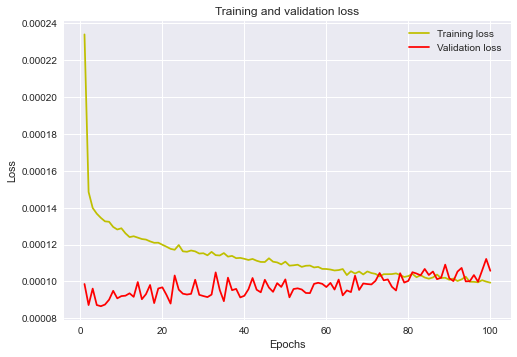

(Date
 2000-11-27         NaN
 2000-11-28   -0.001111
 2000-11-29    0.012602
 2000-11-30   -0.013889
 2000-12-01   -0.005183
                 ...   
 2016-01-22   -0.001729
 2016-01-25   -0.008203
 2016-01-26    0.014012
 2016-01-27   -0.004992
 2016-01-28    0.000448
 Name: strategy, Length: 3803, dtype: float64,
 Date
 2016-01-29    0.000717
 2016-02-01    0.010301
 2016-02-02    0.000532
 2016-02-03    0.012419
 2016-02-04    0.014282
                 ...   
 2020-05-20    0.003669
 2020-05-21   -0.017194
 2020-05-22    0.008195
 2020-05-26   -0.017180
 2020-05-27   -0.003226
 Name: strategy, Length: 1086, dtype: float64,
 Date
 2020-05-28   -0.001754
 2020-05-29   -0.013775
 2020-06-01   -0.000518
 2020-06-02    0.007251
 2020-06-03    0.015882
                 ...   
 2022-07-18    0.003994
 2022-07-19    0.000468
 2022-07-20   -0.006140
 2022-07-21    0.007767
 2022-07-22   -0.008408
 Name: strategy, Length: 544, dtype: float64)

In [4]:
symbol = 'GC=F'
price_type = 'Close'
split_ratio = 0.7
n_hidden_layers = 5
n_neurons = 500
epochs = 100
build_model(symbol,price_type,split_ratio, n_neurons , n_hidden_layers, epochs, folder_name = '26July2022_train')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1346e-04 - mean_absolute_error: 0.0104 - val_loss: 1.1901e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5010e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1968e-04 - val_mean_absolute_error: 0.0082
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4469e-04 - mean_absolute_error: 0.0087 - val_loss: 9.7890e-05 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.3977e-04 - mean_absolute_error: 0.0085 - val_loss: 9.6632e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.3652e-04 - mean_absolute_error: 0.0084 - val_loss: 9.2653e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.3385e-04 - mean_absolute_error: 0.0084 - val_loss: 9.3192e

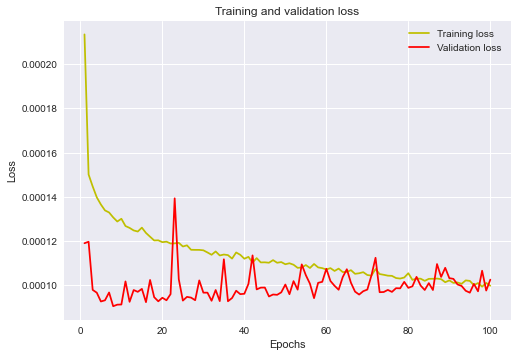

  1%|          | 1/100 [00:44<1:13:25, 44.50s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 1.9534e-04 - mean_absolute_error: 0.0102 - val_loss: 1.4753e-04 - val_mean_absolute_error: 0.0089
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5039e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0363e-04 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4113e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0553e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.3901e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0314e-04 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3658e-04 - mean_absolute_error: 0.0085 - val_loss: 1.1248e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3424e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0640e

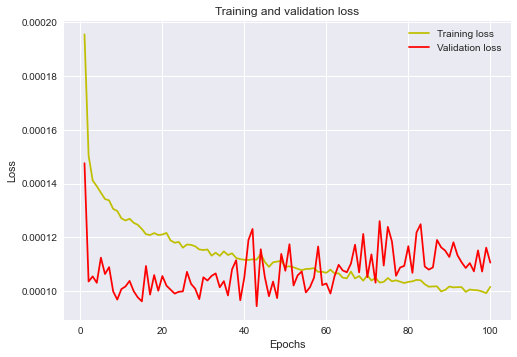

  2%|▏         | 2/100 [01:25<1:09:42, 42.68s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.8097e-04 - mean_absolute_error: 0.0119 - val_loss: 1.1133e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5551e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0913e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4801e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1361e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4404e-04 - mean_absolute_error: 0.0087 - val_loss: 9.8000e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4080e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0186e-04 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3578e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0895e

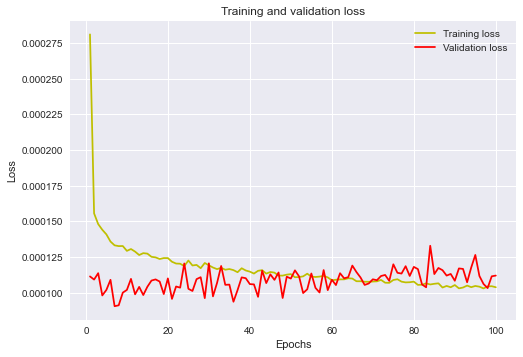

  3%|▎         | 3/100 [02:07<1:07:59, 42.06s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.9363e-04 - mean_absolute_error: 0.0116 - val_loss: 9.2104e-05 - val_mean_absolute_error: 0.0068
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4988e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0974e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4314e-04 - mean_absolute_error: 0.0086 - val_loss: 8.9240e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4103e-04 - mean_absolute_error: 0.0086 - val_loss: 8.7017e-05 - val_mean_absolute_error: 0.0065
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3735e-04 - mean_absolute_error: 0.0085 - val_loss: 9.0455e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3746e-04 - mean_absolute_error: 0.0085 - val_loss: 8.8654e

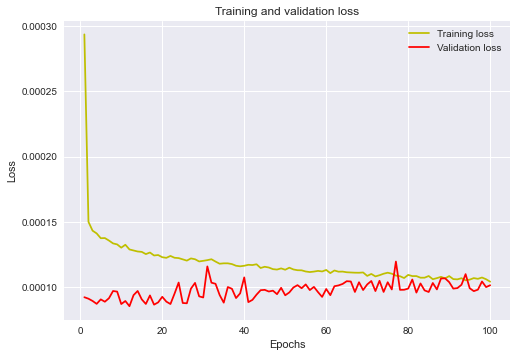

  4%|▍         | 4/100 [02:50<1:07:49, 42.39s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.6809e-04 - mean_absolute_error: 0.0119 - val_loss: 1.0241e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5536e-04 - mean_absolute_error: 0.0091 - val_loss: 9.6669e-05 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4483e-04 - mean_absolute_error: 0.0087 - val_loss: 9.6232e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4044e-04 - mean_absolute_error: 0.0086 - val_loss: 9.6369e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3763e-04 - mean_absolute_error: 0.0085 - val_loss: 8.9345e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3516e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0211e

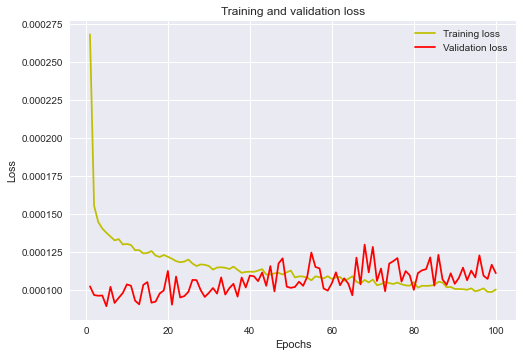

  5%|▌         | 5/100 [03:33<1:07:24, 42.57s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0493e-04 - mean_absolute_error: 0.0104 - val_loss: 1.0264e-04 - val_mean_absolute_error: 0.0070
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4983e-04 - mean_absolute_error: 0.0089 - val_loss: 9.4462e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4322e-04 - mean_absolute_error: 0.0087 - val_loss: 9.2477e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4027e-04 - mean_absolute_error: 0.0086 - val_loss: 8.8217e-05 - val_mean_absolute_error: 0.0064
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3683e-04 - mean_absolute_error: 0.0085 - val_loss: 9.1492e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3600e-04 - mean_absolute_error: 0.0084 - val_loss: 8.7783e

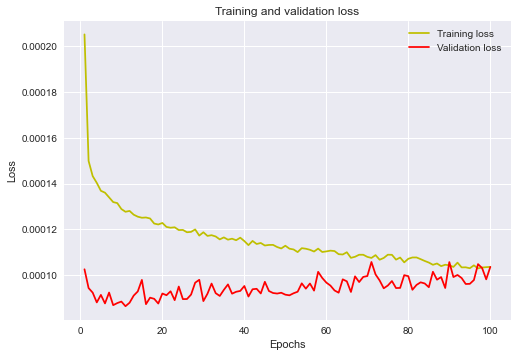

  6%|▌         | 6/100 [04:16<1:07:13, 42.91s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.9143e-04 - mean_absolute_error: 0.0139 - val_loss: 1.4705e-04 - val_mean_absolute_error: 0.0091
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6805e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0962e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5155e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0796e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4743e-04 - mean_absolute_error: 0.0087 - val_loss: 1.1148e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4139e-04 - mean_absolute_error: 0.0086 - val_loss: 9.9581e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3837e-04 - mean_absolute_error: 0.0085 - val_loss: 9.5930e

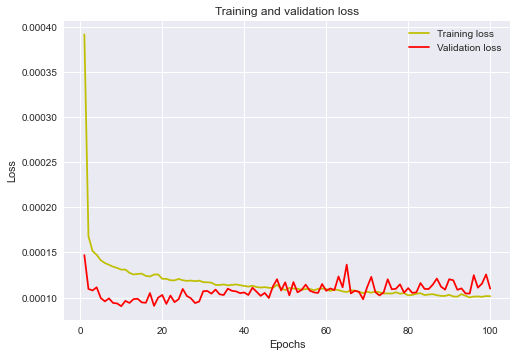

  7%|▋         | 7/100 [04:59<1:06:26, 42.87s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 5.6863e-04 - mean_absolute_error: 0.0162 - val_loss: 1.5308e-04 - val_mean_absolute_error: 0.0094
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5472e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0440e-04 - val_mean_absolute_error: 0.0074
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4446e-04 - mean_absolute_error: 0.0087 - val_loss: 9.6890e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4014e-04 - mean_absolute_error: 0.0086 - val_loss: 9.5104e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3761e-04 - mean_absolute_error: 0.0085 - val_loss: 9.4896e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3615e-04 - mean_absolute_error: 0.0084 - val_loss: 9.8754e

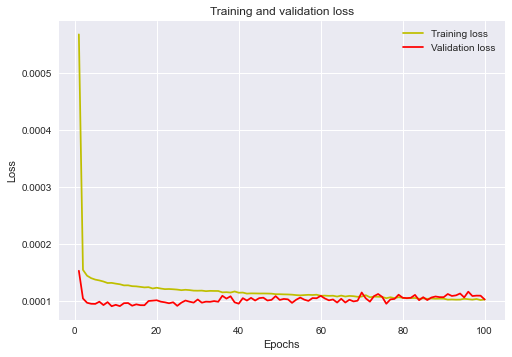

  8%|▊         | 8/100 [05:43<1:06:08, 43.13s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.5438e-04 - mean_absolute_error: 0.0114 - val_loss: 1.1999e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5249e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1965e-04 - val_mean_absolute_error: 0.0077
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4511e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0550e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4302e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0279e-04 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3720e-04 - mean_absolute_error: 0.0085 - val_loss: 9.4403e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3549e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0323e

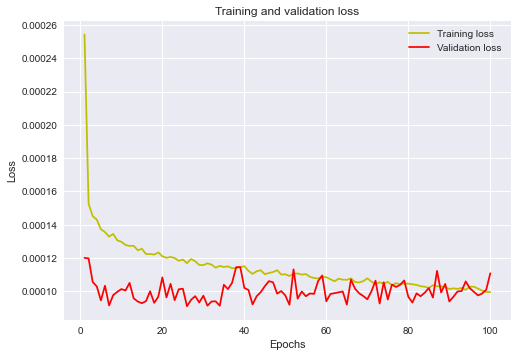

  9%|▉         | 9/100 [06:26<1:05:32, 43.21s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 6.0716e-04 - mean_absolute_error: 0.0155 - val_loss: 1.2398e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6048e-04 - mean_absolute_error: 0.0092 - val_loss: 9.5852e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4811e-04 - mean_absolute_error: 0.0088 - val_loss: 9.1122e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4215e-04 - mean_absolute_error: 0.0086 - val_loss: 9.0412e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4045e-04 - mean_absolute_error: 0.0085 - val_loss: 9.2518e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3845e-04 - mean_absolute_error: 0.0085 - val_loss: 9.3554e

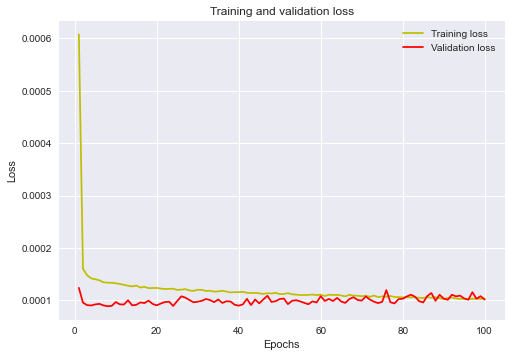

 10%|█         | 10/100 [07:06<1:03:10, 42.12s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.5468e-04 - mean_absolute_error: 0.0115 - val_loss: 1.0616e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5693e-04 - mean_absolute_error: 0.0091 - val_loss: 9.8162e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4790e-04 - mean_absolute_error: 0.0088 - val_loss: 9.4299e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4303e-04 - mean_absolute_error: 0.0087 - val_loss: 1.1242e-04 - val_mean_absolute_error: 0.0077
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4100e-04 - mean_absolute_error: 0.0086 - val_loss: 9.8765e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3734e-04 - mean_absolute_error: 0.0085 - val_loss: 9.2948e

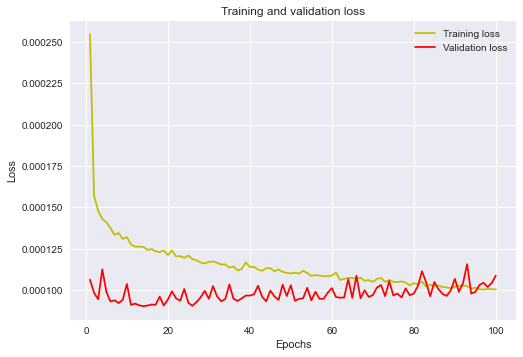

 11%|█         | 11/100 [07:46<1:01:27, 41.43s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0805e-04 - mean_absolute_error: 0.0105 - val_loss: 1.2414e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5163e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0030e-04 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4570e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0490e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4170e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0617e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3620e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0734e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3616e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0133e

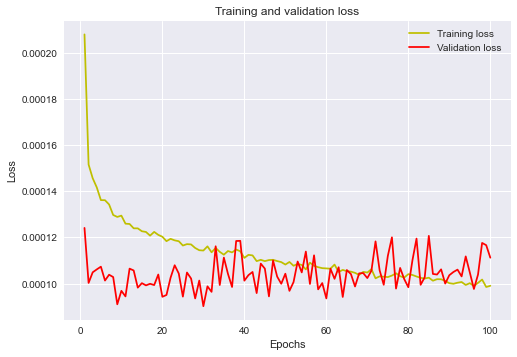

 12%|█▏        | 12/100 [08:25<1:00:04, 40.96s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 3.0152e-04 - mean_absolute_error: 0.0123 - val_loss: 1.2131e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5522e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0403e-04 - val_mean_absolute_error: 0.0072
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4626e-04 - mean_absolute_error: 0.0088 - val_loss: 9.9089e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3908e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0039e-04 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3723e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0034e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3416e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0098e

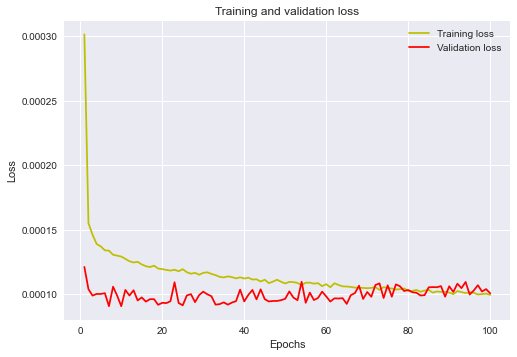

 13%|█▎        | 13/100 [09:05<58:50, 40.58s/it]  

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 3.8033e-04 - mean_absolute_error: 0.0129 - val_loss: 1.0643e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5610e-04 - mean_absolute_error: 0.0091 - val_loss: 9.7327e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4620e-04 - mean_absolute_error: 0.0087 - val_loss: 9.2115e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4221e-04 - mean_absolute_error: 0.0086 - val_loss: 9.5013e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3911e-04 - mean_absolute_error: 0.0086 - val_loss: 9.3867e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3702e-04 - mean_absolute_error: 0.0084 - val_loss: 9.0727e

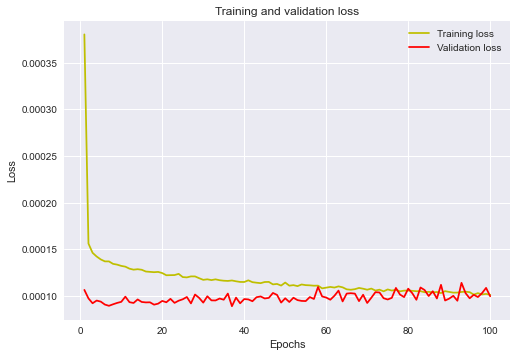

 14%|█▍        | 14/100 [09:46<58:13, 40.62s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.3424e-04 - mean_absolute_error: 0.0110 - val_loss: 1.0727e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5176e-04 - mean_absolute_error: 0.0089 - val_loss: 9.1334e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4233e-04 - mean_absolute_error: 0.0086 - val_loss: 9.8868e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4272e-04 - mean_absolute_error: 0.0086 - val_loss: 9.2745e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3769e-04 - mean_absolute_error: 0.0085 - val_loss: 9.8707e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3537e-04 - mean_absolute_error: 0.0084 - val_loss: 9.1271e

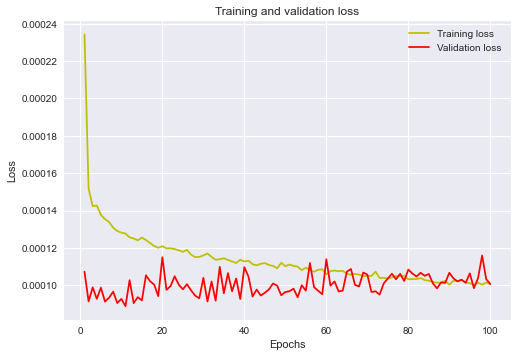

 15%|█▌        | 15/100 [10:26<57:26, 40.55s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.5981e-04 - mean_absolute_error: 0.0114 - val_loss: 1.3996e-04 - val_mean_absolute_error: 0.0087
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5217e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0375e-04 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4368e-04 - mean_absolute_error: 0.0087 - val_loss: 1.1381e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3996e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0997e-04 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3734e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0427e-04 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3602e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0273e

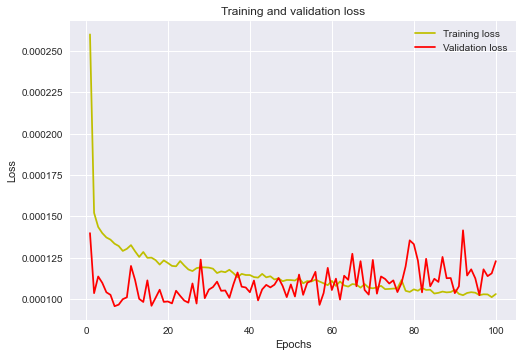

 16%|█▌        | 16/100 [11:07<56:44, 40.53s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0841e-04 - mean_absolute_error: 0.0107 - val_loss: 1.3410e-04 - val_mean_absolute_error: 0.0085
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5272e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1188e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4308e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0985e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3890e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0126e-04 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3702e-04 - mean_absolute_error: 0.0085 - val_loss: 9.4478e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3539e-04 - mean_absolute_error: 0.0085 - val_loss: 1.1911e

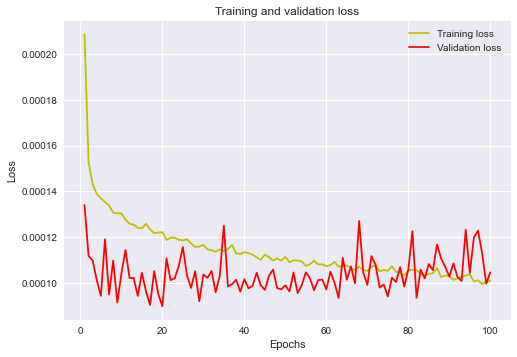

 17%|█▋        | 17/100 [11:47<56:00, 40.49s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.7219e-04 - mean_absolute_error: 0.0118 - val_loss: 9.4604e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5382e-04 - mean_absolute_error: 0.0090 - val_loss: 9.0875e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4651e-04 - mean_absolute_error: 0.0088 - val_loss: 8.9184e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4162e-04 - mean_absolute_error: 0.0086 - val_loss: 9.1706e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3785e-04 - mean_absolute_error: 0.0085 - val_loss: 8.5805e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3448e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0379e

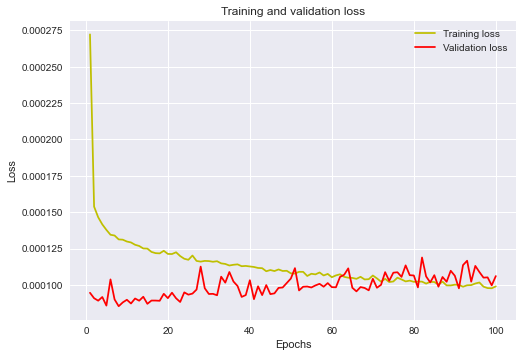

 18%|█▊        | 18/100 [12:27<55:15, 40.43s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.4656e-04 - mean_absolute_error: 0.0112 - val_loss: 1.3042e-04 - val_mean_absolute_error: 0.0082
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4999e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1377e-04 - val_mean_absolute_error: 0.0077
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4396e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0136e-04 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4124e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0032e-04 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3950e-04 - mean_absolute_error: 0.0085 - val_loss: 9.5972e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3685e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0957e

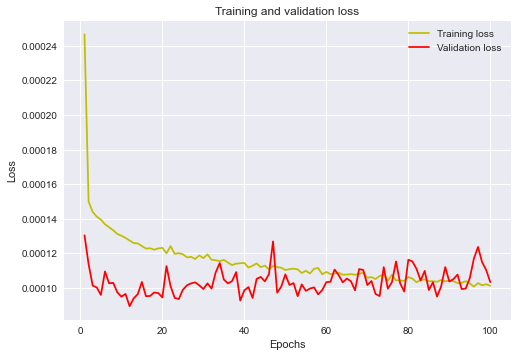

 19%|█▉        | 19/100 [13:08<54:33, 40.41s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1674e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0977e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5421e-04 - mean_absolute_error: 0.0090 - val_loss: 1.3433e-04 - val_mean_absolute_error: 0.0087
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4696e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0442e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4240e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0009e-04 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3928e-04 - mean_absolute_error: 0.0086 - val_loss: 1.1596e-04 - val_mean_absolute_error: 0.0077
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3611e-04 - mean_absolute_error: 0.0084 - val_loss: 9.7353e

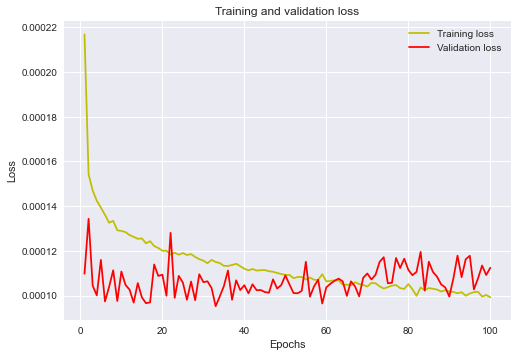

 20%|██        | 20/100 [13:51<55:13, 41.42s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.9471e-04 - mean_absolute_error: 0.0132 - val_loss: 9.5795e-05 - val_mean_absolute_error: 0.0070
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5046e-04 - mean_absolute_error: 0.0089 - val_loss: 8.9939e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4505e-04 - mean_absolute_error: 0.0087 - val_loss: 9.2178e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4184e-04 - mean_absolute_error: 0.0086 - val_loss: 9.5613e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.3916e-04 - mean_absolute_error: 0.0085 - val_loss: 8.6806e-05 - val_mean_absolute_error: 0.0064
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.3609e-04 - mean_absolute_error: 0.0084 - val_loss: 9.7204e

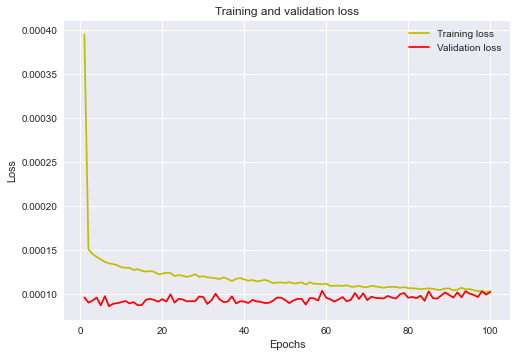

 21%|██        | 21/100 [14:37<56:05, 42.60s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.8329e-04 - mean_absolute_error: 0.0098 - val_loss: 9.8677e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4761e-04 - mean_absolute_error: 0.0088 - val_loss: 9.1783e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4282e-04 - mean_absolute_error: 0.0086 - val_loss: 9.2893e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3900e-04 - mean_absolute_error: 0.0085 - val_loss: 8.9549e-05 - val_mean_absolute_error: 0.0065
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3739e-04 - mean_absolute_error: 0.0085 - val_loss: 9.5073e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3468e-04 - mean_absolute_error: 0.0084 - val_loss: 9.0493e

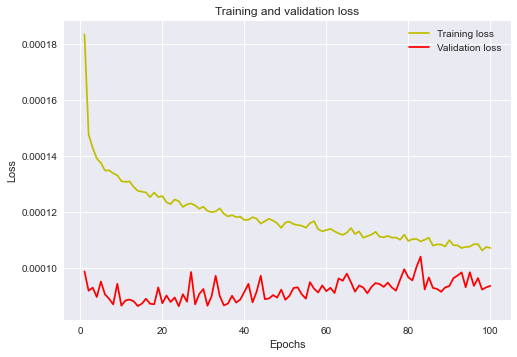

 22%|██▏       | 22/100 [15:18<54:59, 42.30s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.3202e-04 - mean_absolute_error: 0.0110 - val_loss: 1.3034e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5367e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0987e-04 - val_mean_absolute_error: 0.0074
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4628e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0781e-04 - val_mean_absolute_error: 0.0074
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4349e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0432e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3831e-04 - mean_absolute_error: 0.0085 - val_loss: 1.1968e-04 - val_mean_absolute_error: 0.0075
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3533e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0650e

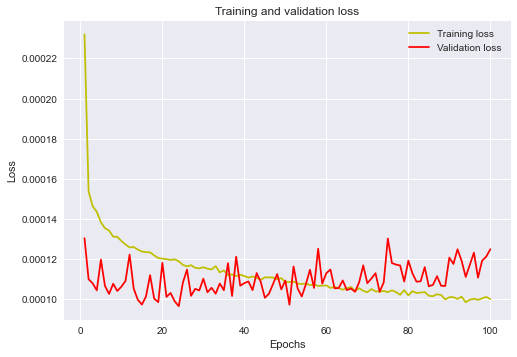

 23%|██▎       | 23/100 [16:00<54:10, 42.21s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2018e-04 - mean_absolute_error: 0.0105 - val_loss: 1.0480e-04 - val_mean_absolute_error: 0.0072
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5204e-04 - mean_absolute_error: 0.0090 - val_loss: 9.8162e-05 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4221e-04 - mean_absolute_error: 0.0087 - val_loss: 9.6986e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4080e-04 - mean_absolute_error: 0.0086 - val_loss: 9.7432e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3674e-04 - mean_absolute_error: 0.0085 - val_loss: 9.6550e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3486e-04 - mean_absolute_error: 0.0084 - val_loss: 9.3802e

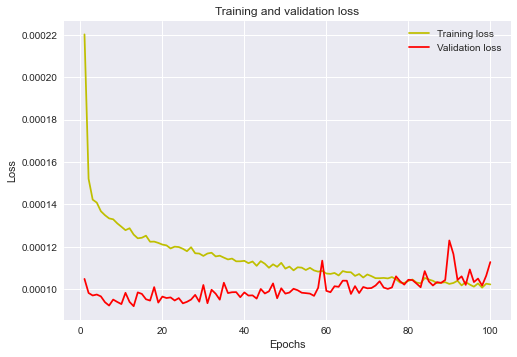

 24%|██▍       | 24/100 [16:41<52:58, 41.82s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 3.2494e-04 - mean_absolute_error: 0.0127 - val_loss: 1.0851e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5428e-04 - mean_absolute_error: 0.0091 - val_loss: 9.3126e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4434e-04 - mean_absolute_error: 0.0087 - val_loss: 9.4150e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4027e-04 - mean_absolute_error: 0.0086 - val_loss: 9.3410e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3830e-04 - mean_absolute_error: 0.0085 - val_loss: 9.2767e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3546e-04 - mean_absolute_error: 0.0085 - val_loss: 9.5040e

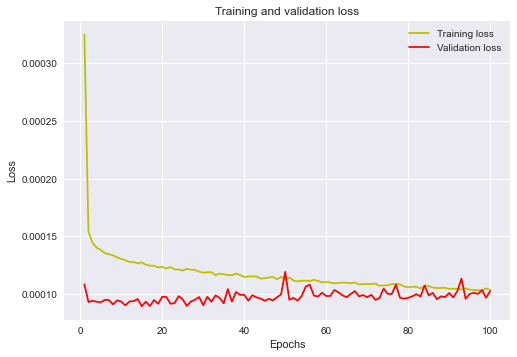

 25%|██▌       | 25/100 [17:22<52:01, 41.61s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 7.3305e-04 - mean_absolute_error: 0.0154 - val_loss: 1.2798e-04 - val_mean_absolute_error: 0.0083
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6265e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0765e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5019e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0209e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4369e-04 - mean_absolute_error: 0.0087 - val_loss: 9.8424e-05 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4238e-04 - mean_absolute_error: 0.0087 - val_loss: 9.4001e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3873e-04 - mean_absolute_error: 0.0086 - val_loss: 9.2223e

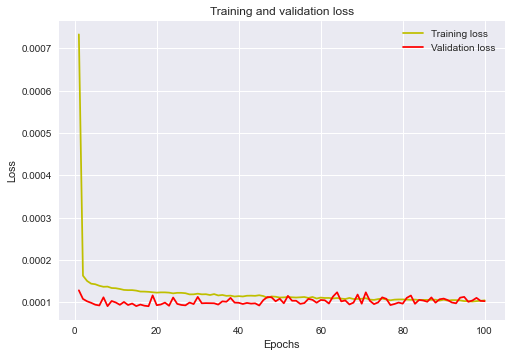

 26%|██▌       | 26/100 [18:04<51:20, 41.63s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 5.4960e-04 - mean_absolute_error: 0.0160 - val_loss: 1.2622e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6626e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0079e-04 - val_mean_absolute_error: 0.0072
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5285e-04 - mean_absolute_error: 0.0089 - val_loss: 9.3272e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4657e-04 - mean_absolute_error: 0.0087 - val_loss: 9.4548e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4326e-04 - mean_absolute_error: 0.0086 - val_loss: 9.1531e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3917e-04 - mean_absolute_error: 0.0085 - val_loss: 9.1138e

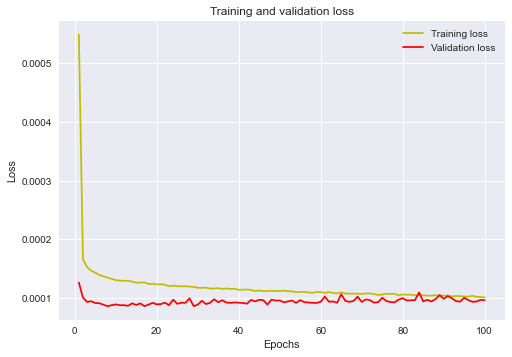

 27%|██▋       | 27/100 [18:45<50:25, 41.44s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 8.8185e-04 - mean_absolute_error: 0.0197 - val_loss: 1.2860e-04 - val_mean_absolute_error: 0.0083
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.7032e-04 - mean_absolute_error: 0.0096 - val_loss: 1.0685e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5210e-04 - mean_absolute_error: 0.0090 - val_loss: 9.8352e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4555e-04 - mean_absolute_error: 0.0088 - val_loss: 9.4977e-05 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4138e-04 - mean_absolute_error: 0.0086 - val_loss: 9.3200e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3869e-04 - mean_absolute_error: 0.0085 - val_loss: 9.2148e

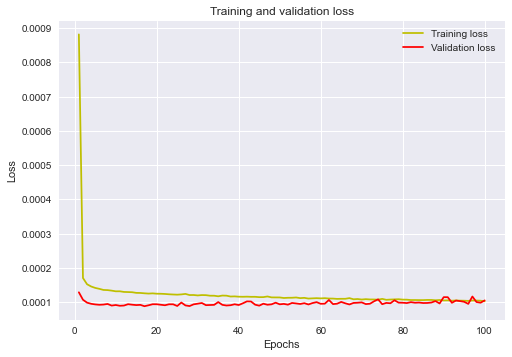

 28%|██▊       | 28/100 [19:26<49:38, 41.37s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.9636e-04 - mean_absolute_error: 0.0120 - val_loss: 9.8161e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5110e-04 - mean_absolute_error: 0.0089 - val_loss: 9.2654e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4292e-04 - mean_absolute_error: 0.0087 - val_loss: 9.4569e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3979e-04 - mean_absolute_error: 0.0086 - val_loss: 9.3532e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3675e-04 - mean_absolute_error: 0.0085 - val_loss: 9.6585e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3426e-04 - mean_absolute_error: 0.0084 - val_loss: 9.4846e

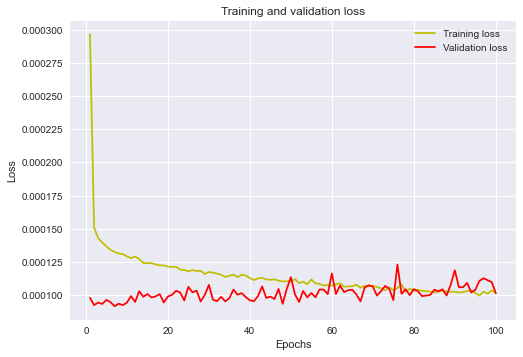

 29%|██▉       | 29/100 [20:08<49:10, 41.56s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 3.1724e-04 - mean_absolute_error: 0.0126 - val_loss: 1.1965e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4994e-04 - mean_absolute_error: 0.0089 - val_loss: 9.9545e-05 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4405e-04 - mean_absolute_error: 0.0086 - val_loss: 9.9596e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4001e-04 - mean_absolute_error: 0.0085 - val_loss: 9.4905e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3717e-04 - mean_absolute_error: 0.0085 - val_loss: 9.6400e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3448e-04 - mean_absolute_error: 0.0084 - val_loss: 9.2631e

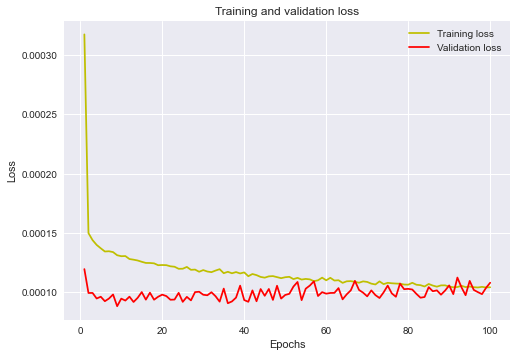

 30%|███       | 30/100 [20:50<48:36, 41.66s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 6.7494e-04 - mean_absolute_error: 0.0169 - val_loss: 1.1618e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7351e-04 - mean_absolute_error: 0.0096 - val_loss: 1.0236e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5411e-04 - mean_absolute_error: 0.0090 - val_loss: 9.8599e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4670e-04 - mean_absolute_error: 0.0088 - val_loss: 9.4593e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4451e-04 - mean_absolute_error: 0.0087 - val_loss: 9.5439e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4092e-04 - mean_absolute_error: 0.0086 - val_loss: 9.0677e

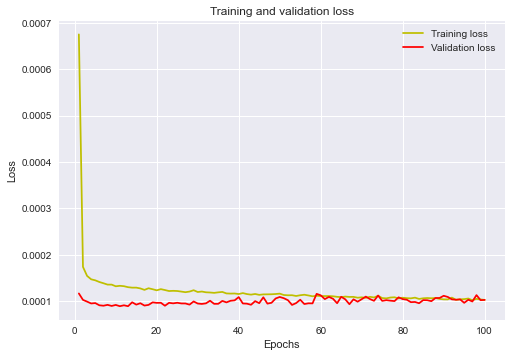

 31%|███       | 31/100 [21:32<47:58, 41.72s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9415e-04 - mean_absolute_error: 0.0101 - val_loss: 9.6577e-05 - val_mean_absolute_error: 0.0067
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4668e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0387e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4148e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0927e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3794e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0078e-04 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3481e-04 - mean_absolute_error: 0.0084 - val_loss: 1.0307e-04 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3247e-04 - mean_absolute_error: 0.0083 - val_loss: 9.4020e

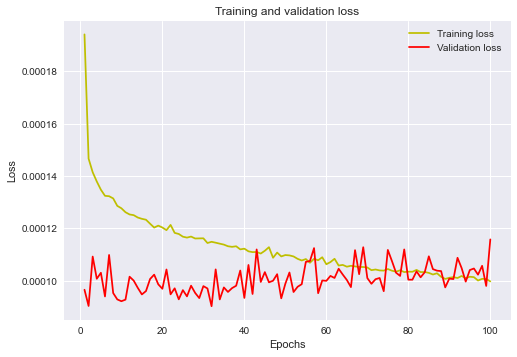

 32%|███▏      | 32/100 [22:14<47:27, 41.87s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.3411e-04 - mean_absolute_error: 0.0108 - val_loss: 1.0651e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5202e-04 - mean_absolute_error: 0.0089 - val_loss: 9.7104e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4603e-04 - mean_absolute_error: 0.0087 - val_loss: 9.5958e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4321e-04 - mean_absolute_error: 0.0086 - val_loss: 9.4621e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3798e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0050e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3752e-04 - mean_absolute_error: 0.0085 - val_loss: 9.5850e

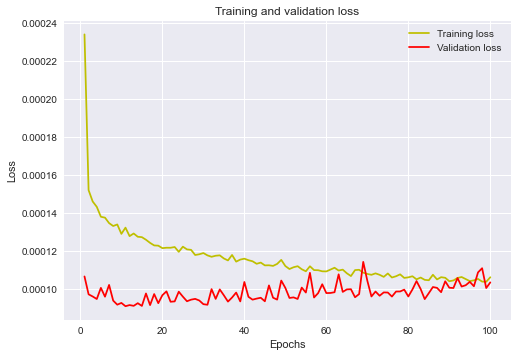

 33%|███▎      | 33/100 [22:57<46:55, 42.02s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.8702e-04 - mean_absolute_error: 0.0123 - val_loss: 1.2536e-04 - val_mean_absolute_error: 0.0082
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5788e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0740e-04 - val_mean_absolute_error: 0.0077
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5014e-04 - mean_absolute_error: 0.0089 - val_loss: 9.9046e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4312e-04 - mean_absolute_error: 0.0086 - val_loss: 9.7275e-05 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3967e-04 - mean_absolute_error: 0.0086 - val_loss: 9.8423e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3565e-04 - mean_absolute_error: 0.0084 - val_loss: 9.4589e

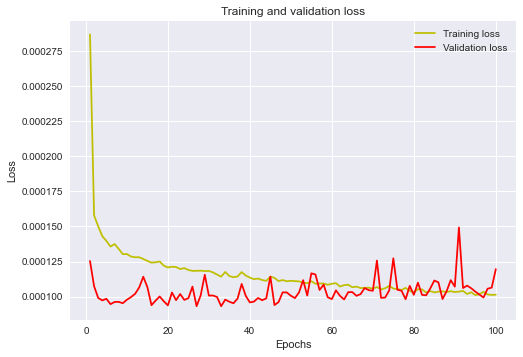

 34%|███▍      | 34/100 [23:39<46:16, 42.06s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.5247e-04 - mean_absolute_error: 0.0112 - val_loss: 1.0532e-04 - val_mean_absolute_error: 0.0072
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5373e-04 - mean_absolute_error: 0.0090 - val_loss: 9.7745e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4590e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0143e-04 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4101e-04 - mean_absolute_error: 0.0086 - val_loss: 9.3968e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4039e-04 - mean_absolute_error: 0.0086 - val_loss: 9.4742e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3659e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0095e

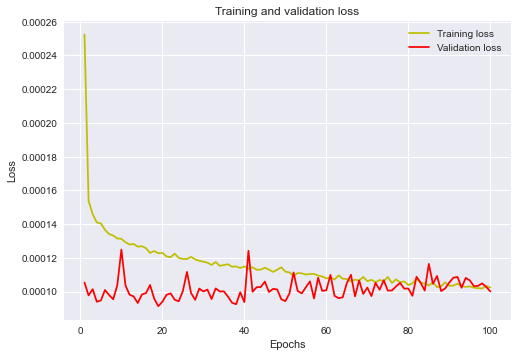

 35%|███▌      | 35/100 [24:22<45:58, 42.44s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 9.7256e-04 - mean_absolute_error: 0.0202 - val_loss: 1.3380e-04 - val_mean_absolute_error: 0.0083
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7076e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0248e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5376e-04 - mean_absolute_error: 0.0090 - val_loss: 9.5866e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4586e-04 - mean_absolute_error: 0.0087 - val_loss: 9.3286e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4096e-04 - mean_absolute_error: 0.0085 - val_loss: 9.1961e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.3835e-04 - mean_absolute_error: 0.0085 - val_loss: 9.6146e

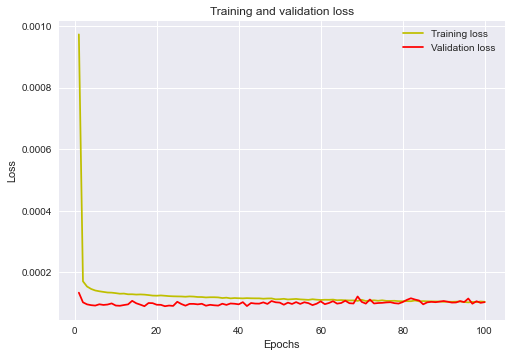

 36%|███▌      | 36/100 [2:14:05<3:58:23, 223.49s/it]  


ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Max retries exceeded with url: /quote/GC=F/history?period1=967600800&period2=1658541599&interval=1d&frequency=1d&filter=history (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000249A5593850>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [5]:
# library to estimate the time until the end of the loop

from tqdm import tqdm

return_test = []
return_val = []

# compute the return during the test and validation period

for i in tqdm(range(100)):
    train,val,test = build_model(symbol,price_type,split_ratio, n_neurons , n_hidden_layers, epochs, folder_name = '26July2022_test1')
    return_test.append(test)
    return_val.append(val)